In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('./DropEdge/src'))

In [2]:
from models import *
from sample import Sampler
from metric import accuracy, roc_auc_compute_fn
import numpy as np
import pickle
import tqdm.notebook

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.parameter import Parameter

import matplotlib.pyplot as plt
%matplotlib inline


Set random states and configs

In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# random seed setting
np.random.seed(42)
torch.manual_seed(42)
if device == torch.device('cuda'):
    torch.cuda.manual_seed(42)

config = {
    'nhid': 128,
    'nhidlayer': 1,
    'dropout': 0.5,
    'baseblock': 'inceptiongcn',
    'inputlayer': 'gcn',
    'outputlayer': 'gcn',
    'nbaselayer': 4,
    'withbn': False,
    'withloop': False,
    'aggrmethod': 'concat',
    'mixmode': False,
    'model_path': './tmpmodels/tmp-1218-171657-IHUend.pt',
    'dataset': 'cora',
    'datapath': './DropEdge/data//',
    'task_type': 'full',
    'normalization': 'AugNormAdj'
}

sampler = Sampler(config['dataset'], config['datapath'], config['task_type'])

# get labels and indexes
labels, idx_train, idx_val, idx_test = sampler.get_label_and_idxes(device == torch.device('cuda'))
nfeat = sampler.nfeat
nclass = sampler.nclass

config['nfeat'] = nfeat
config['nclass'] = nclass

Load full supervised task.


Firstly, we need load trained model and see to train/valid losses durring the traning

In [11]:
base_model = GCNModel(nfeat=config["nfeat"],
                      nhid=config['nhid'],
                      nclass=config["nclass"],
                      nhidlayer=config['nhidlayer'],
                      dropout=config['dropout'],
                      baseblock=config['baseblock'],
                      inputlayer=config['inputlayer'],
                      outputlayer=config['outputlayer'],
                      nbaselayer=config['nbaselayer'],
                      activation=F.relu,
                      withbn=config['withbn'],
                      withloop=config['withloop'],
                      aggrmethod=config['aggrmethod'],
                      mixmode=config['mixmode'])

if device == torch.device('cuda'):
    state_dict = torch.load(config['model_path'])
else:
    state_dict = torch.load(config['model_path'], map_location=torch.device('cpu'))
    
base_model.load_state_dict(state_dict)

<All keys matched successfully>

### Overfitting
Approximately on epoch 50 we can see start of overfitting

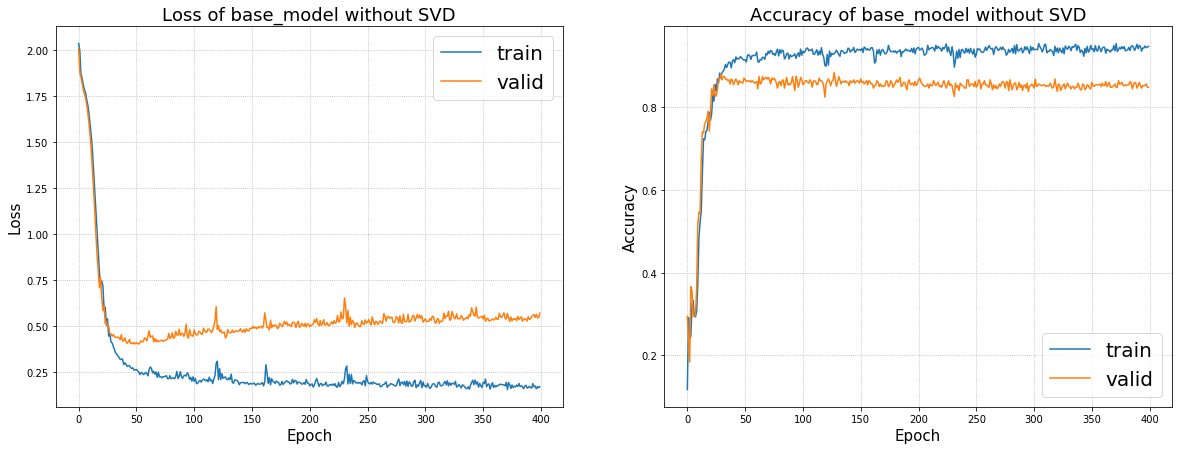

In [14]:
with open('./tmpmodels/tmp-1218-154138-jcy.pkl', 'rb') as f:
    stats = pickle.load(f)
    
loss_train = stats['loss_train']
loss_val = stats['loss_val']
loss_test = stats['loss_test']

acc_train = stats['acc_train']
acc_val = stats['acc_val']
acc_test = stats['acc_test']

fig,axs = plt.subplots(1, 2)
fig.set_size_inches(20, 7)

axs[0].plot(stats['loss_train'], label='train')
axs[0].plot(stats['loss_val'], label='valid')
axs[0].legend(fontsize=20)
axs[0].set_title("Loss of base_model without SVD", fontsize=18)
axs[0].set_xlabel("Epoch", fontsize=15)
axs[0].set_ylabel("Loss", fontsize=15)
axs[0].grid(ls=":")

axs[1].plot(stats['acc_train'], label='train')
axs[1].plot(stats['acc_val'], label='valid')
axs[1].legend(fontsize=20)
axs[1].set_title("Accuracy of base_model without SVD", fontsize=18)
axs[1].set_xlabel("Epoch", fontsize=15)
axs[1].set_ylabel("Accuracy", fontsize=15)
axs[1].grid(ls=":")

### Prepare methods for testing

In [15]:
def test(model, test_adj, test_fea):
    model.eval()
    output = model(test_fea, test_adj)
    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    return loss_test.item(), acc_test.item()


if device == torch.device('cuda'):
    labels = labels.cuda()
    idx_train = idx_train.cuda()
    idx_val = idx_val.cuda()
    idx_test = idx_test.cuda()
    
(test_adj, test_fea) = sampler.get_test_set(
    normalization=config['normalization'],
    cuda= device == torch.device('cuda')
)

In [16]:
base_loss_test, base_acc_test = test(base_model, test_adj, test_fea)
print(f"Loss test on base_model = {base_loss_test}\nAcc test of base_model = {base_acc_test}")

Loss test on base_model = 0.6034193634986877
Acc test of base_model = 0.84


### SVD vs Overfit

Now we are ready for making model clone with low rank approximation via SVD

Here, $r$ is rank for $r$-rank approximation

In [17]:
class GraphConvolutionBSSVD(Module):
    def __init__(self, orig_layer, r):
        super(GraphConvolutionBSSVD, self).__init__()
        self.r = r
        
        self.in_features = orig_layer.in_features
        self.out_features = orig_layer.out_features
        self.sigma = orig_layer.sigma
        
        U, s, V = torch.svd(orig_layer.weight)
        
        self.U = nn.Parameter(U[:, :r])
        self.s = nn.Parameter(s[:r])
        self.Vt = nn.Parameter(V.T[:r, :])
        
        if orig_layer.bias is not None:
            self.bias = Parameter(orig_layer.bias)
        else:
            self.register_parameter('bias', None)


    def forward(self, input, adj):
        support = torch.mm(input, self.U)
        support = support * self.s
        support = torch.mm(support, self.Vt)
        output = torch.spmm(adj, support)
        
        if self.bias is not None:
            output = output + self.bias
        
        return self.sigma(output)

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) \
               + ', ' + str(self.r) + ')'

### Experiments

In [18]:
import copy

def transform_model(model, idx, r):
    for i in range(idx + 1):
        model.midlayer[0].midlayers[idx][i] = \
            GraphConvolutionBSSVD(model.midlayer[0].midlayers[idx][i], r)

def make_new_model(model, r):
    new_model = copy.deepcopy(model)
    new_model.ingc = GraphConvolutionBSSVD(new_model.ingc, r)
    transform_model(new_model, 0, 3)
    transform_model(new_model, 1, 3)
    transform_model(new_model, 2, 3)
    transform_model(new_model, 3, 3)
    new_model.to(device)
    return new_model


In [91]:
model = make_new_model(base_model, 10)
loss_test, acc_test = test(model, test_adj, test_fea)
print(f"Loss test on base_model with low rank approximation = {loss_test}\n",
      f"Acc test of base_model with low rank approximation = {acc_test}")

Loss test on base_model with low rank approximation = 0.570661187171936
 Acc test of base_model with low rank approximation = 0.846


In [92]:
experiments = {
    'r': [],
    'loss': [],
    'acc': []
}

for r in tqdm.notebook.tqdm(range(2, 120)):
    model = make_new_model(base_model, r)
    loss_test, acc_test = test(model, test_adj, test_fea)
    experiments['r'].append(r)
    experiments['loss'].append(loss_test)
    experiments['acc'].append(acc_test)
    del model

(0.56, 0.65)

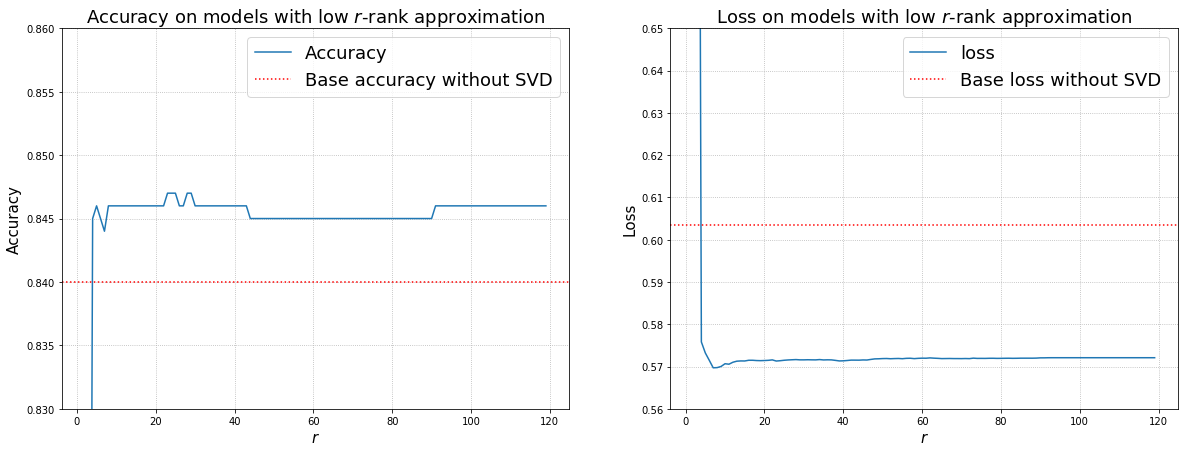

In [101]:
fig,axs = plt.subplots(1, 2)
fig.set_size_inches(20, 7)

axs[0].plot(experiments['r'], experiments['acc'], label='Accuracy')
axs[0].axhline(y=base_acc_test, color='r', linestyle=':', label="Base accuracy without SVD")
axs[0].legend(fontsize=18)
axs[0].set_title("Accuracy on models with low $r$-rank approximation", fontsize=18)
axs[0].set_ylabel("Accuracy", fontsize=15)
axs[0].set_xlabel("$r$", fontsize=15)
axs[0].grid(ls=":")
axs[0].set_ylim((0.83, 0.86))

axs[1].plot(experiments['r'], experiments['loss'], label='loss')
axs[1].axhline(y=base_loss_test, color='r', linestyle=':', label="Base loss without SVD")
axs[1].legend(fontsize=18)
axs[1].set_title("Loss on models with low $r$-rank approximation", fontsize=18)
axs[1].set_ylabel("Loss", fontsize=15)
axs[1].set_xlabel("$r$", fontsize=15)
axs[1].grid(ls=":")
axs[1].set_ylim((0.56, 0.65))

In [94]:
best_r_idx = np.argmax(experiments['acc'])
print(f"Best rank for this mode is {experiments['r'][best_r_idx]}")
print(f"Accuracy: {experiments['acc'][best_r_idx]}")
print(f"Loss:     {experiments['loss'][best_r_idx]}\n")

print(f"Loss test on base_model = {base_loss_test}")
print(f"Acc test of base_model = {base_acc_test}")

Best rank for this mode is 23
Accuracy: 0.847
Loss:     0.5712956190109253

Loss test on base_model = 0.6034193634986877
Acc test of base_model = 0.84


## Bonus (Speed up)

In [169]:
experiments['eval_time'] = []

base_model.eval()
time_for_base_model = %timeit -o -q -r 5 base_model(test_fea, test_adj)
time_for_base_model = time_for_base_model.average

for r in tqdm.notebook.tqdm(range(2, 120)):
    model = make_new_model(base_model, r)
    time_for_model = %timeit -o -q -r 5 model(test_fea, test_adj)
    experiments['eval_time'].append(time_for_model.average)
    del model
    time.sleep(2)

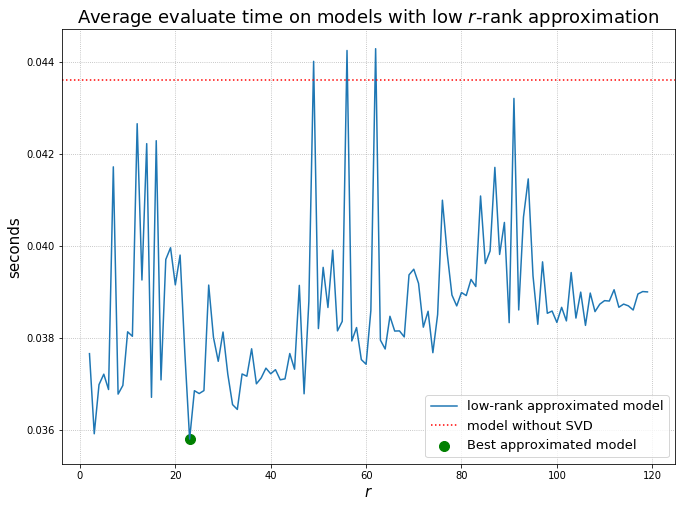

In [170]:
fig,ax = plt.subplots(1, 1)
fig.set_size_inches(11, 8)

ax.plot(experiments['r'], experiments['eval_time'], label='low-rank approximated model')
ax.axhline(y=time_for_base_model, color='r', linestyle=':', label="model without SVD")
ax.scatter([experiments['r'][best_r_idx]], [experiments['eval_time'][best_r_idx]], marker='o', color='green', s=100, label="Best approximated model")
ax.legend(fontsize=13)
ax.set_title("Average evaluate time on models with low $r$-rank approximation", fontsize=18)
ax.set_ylabel("seconds", fontsize=15)
ax.set_xlabel("$r$", fontsize=15)
ax.grid(ls=":")